In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import basinhopping
import pandas as pd

In [2]:
from validation.TensileExperimental import TensileExperimental

r = TensileExperimental()

df       = r["df"]
df_stats = r["df_stats"]

In [3]:
df_stats.round(2)

Modulo (GPa)       Espesor (mm)             layers v [X,SX,Y,SY] ni
             mean   std         mean   std                              
Name                                                                    
TFP1         2.89  0.23         5.27  0.06          [Y]  [0, 0, 1, 0]  1
TFP2         2.26  0.07         4.70  0.00       [Y, X]  [1, 0, 1, 0]  2
TFP3         2.00  0.00         4.83  0.06      [Y, SX]  [0, 1, 1, 0]  2
TFP4         2.45  0.11         4.70  0.00      [Y, SY]  [0, 0, 1, 1]  2
TFP5         1.63  0.12         5.70  0.00  [Y, SX, SY]  [0, 1, 1, 1]  3
TFP6         1.74  0.07         5.60  0.00   [Y, X, SY]  [1, 0, 1, 1]  3

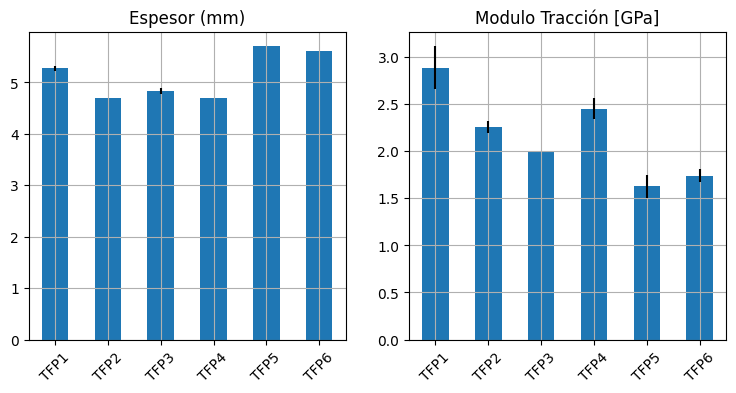

In [4]:
from validation.TensileExperimental import TensilePlotData

TensilePlotData(df_stats)

In [5]:
# only thin 

ni = df_stats["ni"].values
tau_exp = df_stats["Espesor (mm)"]["mean"].values

tau_pred_fcn = lambda tn,tl: tn + 2*tl*ni

In [6]:
def E_effective_j(tn,tl,En,Evec,j):
    
    tau_pred = tau_pred_fcn(tn,tl)

    delta_j  = df_stats["v [X,SX,Y,SY]"].iloc[j]

    tau_j    = tau_pred[j]

    return (En*tn + 2*tl*(np.dot(delta_j,Evec)))/tau_j

def E_effective(En,Evec,tn,tl):
    return np.array([E_effective_j(tn,tl,En,Evec,j) 
                     for j in range(len(df_stats))])


In [7]:
E_eff_exp = df_stats["Modulo (GPa)"]["mean"].values

Evec_0 = np.array([1,0,0,0])
En_0 = 100
tn_0 = 1
tl_0 = 1

E_eff_pred = E_effective(En_0,Evec_0,tn_0,tl_0)
tau_pred = tau_pred_fcn(tn_0,tl_0)

In [8]:
from validation.experimental import  nucleo

In [9]:
E_nucleo_exp_Mpa = nucleo()["young modulus [MPa]"]
E_nucleo_exp = E_nucleo_exp_Mpa/1000
print(E_nucleo_exp)

0.8


In [10]:
def theta(x):
    return 0.5*(np.sign(x)+1)

relu = lambda x: x*theta(x)

In [11]:
from validation.experimental import manual_data

from validation.experimental import manual_data

t_nucleo_exp = manual_data()["t_nucleo [mm]"] = manual_data()["t_nucleo [mm]"]

In [12]:
# minimize 
def objective_E(En,Evec,tn,tl):
    Loss_E   = sum((E_effective(En,Evec,tn,tl) - E_eff_exp)**2)
    Loss_tau = 1e-1*sum((tau_pred_fcn(tn,tl) - tau_exp)**2)
    
    # En < Evec[0]
    lag_mult = 1e6*relu( En - Evec[0]) # Asumimos que el nucleo es el material más blando que la capas E[0] -> X
    
    return Loss_E + Loss_tau + 0*lag_mult
           

x0 = np.random.rand(7)
# must be positive 

bounds = [  (E_nucleo_exp*0.9,1.1*E_nucleo_exp), # En
            (0.100,None), # Evec[0]   # X
            (0.100,None), # Evec[1]   # Y
            (0.100,None), # Evec[2]   # SX
            (0.100,None), # Evec[3]   # SY
            (0.9*t_nucleo_exp,1.1*t_nucleo_exp), # tn
            (0.25,2)  # tl
            ]

bounds = [  (E_nucleo_exp*0.9,1.1*E_nucleo_exp), # En
            (0.0,None), # Evec[0]   # X
            (0.0,None), # Evec[1]   # Y
            (0.0,None), # Evec[2]   # SX
            (0.0,None), # Evec[3]   # SY
            (0.9*t_nucleo_exp,1.1*t_nucleo_exp), # tn
            (0.25,2)  # tl
            ]
          
# set constraints
if x0[1] < x0[0]:
    x0[1] = x0[0]

for k,ib in enumerate(bounds):

    if ib[0] is not None and x0[k] < ib[0]:
        x0[k] = ib[0]
    if ib[1] is not None and x0[k] > ib[1]:
        x0[k] = ib[1]

minimizer_kwargs = {"method": "trust-constr",
                    "bounds": bounds}

res = basinhopping(lambda x: objective_E(x[0],x[1:5],x[5],x[6]),
                x0, 
                minimizer_kwargs=minimizer_kwargs,
                niter=5)

En_opt   = res.x[0]
Evec_opt = res.x[1:5]
tn_opt   = res.x[5]
tl_opt   = res.x[6]

E_eff_pred = E_effective(En_opt,Evec_opt,tn_opt,tl_opt)
tau_pred   = tau_pred_fcn(tn_opt,tl_opt)

In [13]:
df_stats

Modulo (GPa)           Espesor (mm)                 layers v [X,SX,Y,SY]  \
             mean       std         mean       std                              
Name                                                                            
TFP1     2.885509  0.227295     5.266667  0.057735          [Y]  [0, 0, 1, 0]   
TFP2     2.258503  0.065626     4.700000  0.000000       [Y, X]  [1, 0, 1, 0]   
TFP3     2.000437  0.004435     4.833333  0.057735      [Y, SX]  [0, 1, 1, 0]   
TFP4     2.451362  0.114353     4.700000  0.000000      [Y, SY]  [0, 0, 1, 1]   
TFP5     1.626582  0.120272     5.700000  0.000000  [Y, SX, SY]  [0, 1, 1, 1]   
TFP6     1.739870  0.067515     5.600000  0.000000   [Y, X, SY]  [1, 0, 1, 1]   

     ni  
         
Name     
TFP1  1  
TFP2  2  
TFP3  2  
TFP4  2  
TFP5  3  
TFP6  3

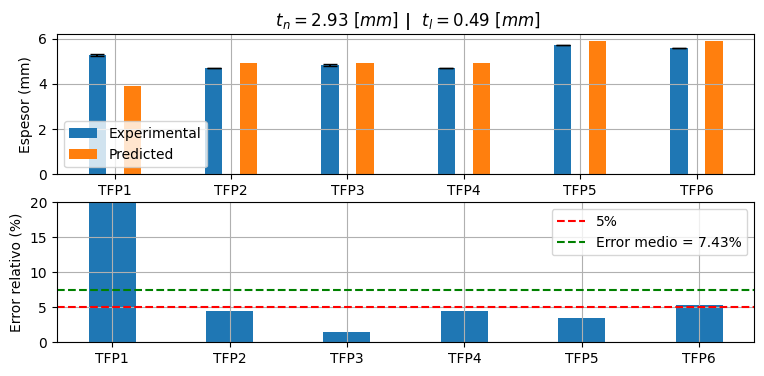

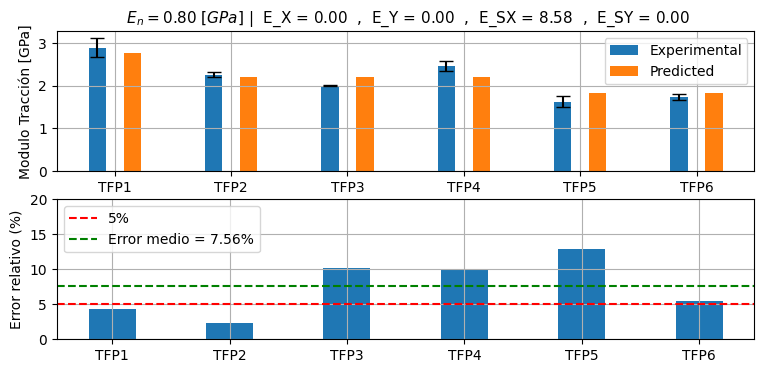

In [14]:
from AnalyticalLayers.plot_E import plot_E
from AnalyticalLayers.plt_thin import plt_thin

plt_thin(df_stats, tau_exp, tau_pred, tn_opt, tl_opt)
plot_E(df_stats, E_eff_exp, E_eff_pred, Evec_opt, En_opt)

In [15]:
df_layers = pd.DataFrame({"Evec [GPa]": Evec_opt}, index=["X","SX","Y","SY"])
# add nuclueo
df_layers.loc["Nucleo"] = [En_opt]
df_layers.round(2)

,Evec [GPa]
X,0.00
SX,0.00
Y,8.58
SY,0.00
Nucleo,0.80


In [16]:
df_thickness = pd.DataFrame({"t [mm]": [tn_opt, tl_opt]}, index=["Nucleo","Capas"])

df_thickness.round(2)

,t [mm]
Nucleo,2.93
Capas,0.49


In [17]:
print("Optimal En: ", En_opt)
print("Optimal Evec: ", Evec_opt)
print("Optimal tn: ", tn_opt)
print("Optimal tl: ", tl_opt)

Optimal En:  0.8031036804155708
Optimal Evec:  [1.13114397e-06 1.36139088e-07 8.57591827e+00 1.88363476e-06]
Optimal tn:  2.933629148734852
Optimal tl:  0.49343387646988274


In [19]:
df_pred = {
    "Name"          : df_stats.index,
    "E pred [GPa]"  : E_eff_pred,
    "E exp [GPa]"   : E_eff_exp,
    "E e rel [%]"   : 100*abs(E_eff_exp - E_eff_pred)/E_eff_exp,
    "t pred [mm]"   : tau_pred,
    "t exp [mm]"    : tau_exp,
    "t e rel [%]"   : 100*abs(tau_exp - tau_pred)/tau_exp
}
df_pred = pd.DataFrame(df_pred)
# decimals
df_pred = df_pred.round(2)
df_pred.head()

,Name,E pred [GPa],E exp [GPa],E e rel [%],t pred [mm],t exp [mm],t e rel [%]
0,TFP1,2.76,2.89,4.36,3.92,5.27,25.56
1,TFP2,2.20,2.26,2.38,4.91,4.70,4.41
2,TFP3,2.20,2.00,10.21,4.91,4.83,1.53
3,TFP4,2.20,2.45,10.06,4.91,4.70,4.41
4,TFP5,1.84,1.63,12.85,5.89,5.70,3.41


In [20]:
Em_error = np.mean(df_pred["E e rel [%]"])
tm_error = np.mean(df_pred["t e rel [%]"])

from loadsavejson.savejson import savejson

savejson({"layers":df_layers, 
            "errors": {"E":Em_error, "t":tm_error},
          "thickness":df_thickness},
          "df_opt_free_thin.json")